In [29]:
%load_ext autoreload
%autoreload 2

import os

from TaylorF2 import TaylorF2
import numpy as np
import torch
import torchvision.datasets as dset
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from torch import tensor

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam , RMSprop

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# pyro.enable_validation(True)
# pyro.distributions.enable_validation(False)
# pyro.set_rng_seed(0)
# smoke_test = 'CI' in os.environ

### Load training and test data

In [33]:
train_set = np.loadtxt('./training_set 2.txt')
test_set = np.loadtxt('./testing_set.txt')

In [34]:
### normalise 
train_set = train_set * 5 * 10**-1
test_set = test_set  * 5 * 10**-1

### Plot to check they look sensible

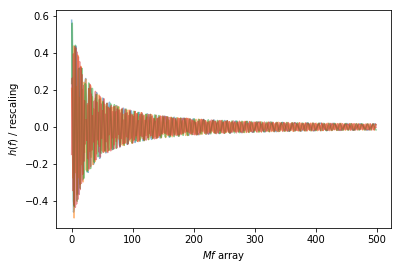

In [35]:
for curve in train_set[0:4]:
    plt.plot( curve , alpha = 0.5)
plt.xlabel(r'$Mf$ array')
plt.ylabel(r'$ h(f)$ / rescaling')
plt.show()

### Change training set to tensor

In [36]:
x_train = torch.tensor(train_set , dtype = torch.float32)
x_test = torch.tensor(test_set , dtype = torch.float32)

### Use data loader function to make minibatches, following similar procedure as in VAE tutorial ( probably not necessary as can generate datset here)

In [37]:
def setup_data_loaders(batch_size, use_cuda=False):
    train_set = x_train
    test_set = x_test
    covariance = torch.eye(n_points)
    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    cov_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    return train_loader, test_loader

In [38]:
n_points = len(x_train[0])

In [39]:
train_loader , test_loader = setup_data_loaders(batch_size= 64
                                                ,use_cuda=False)

### Define encoder and decoder 


In [40]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Encoder, self).__init__()
        # setup the linear transformations used
        self.fc1 = nn.Linear(n_points, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim , int(hidden_dim/2))
        self.fc3 = nn.Linear(int(hidden_dim/2) , int(hidden_dim/4))
        self.fc41 = nn.Linear(int(hidden_dim/4), z_dim)
        self.fc42 = nn.Linear(int(hidden_dim/4.), z_dim)
        # setup the non-linearities
        self.relu = nn.ReLU()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, n_points)
        # then compute the hidden units
        hidden1 = self.relu(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        layer2 = self.fc2(hidden1)
        hidden2 = self.relu(layer2)
        layer3 = self.fc3(hidden2)
        hidden3 = self.relu(layer3)
        # here we have compressed the waveform into the z latent variables
        z_loc = self.fc41(hidden3)
        z_scale = torch.exp(self.fc42(hidden3))
        return z_loc, z_scale

In [41]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Decoder, self).__init__()
        # setup the linear layers, define their input and output shape
        # start with z nodes and then decompress back to the true waveform shape
        self.fc1 = nn.Linear(z_dim, int(hidden_dim/4))
        self.fc2 = nn.Linear(int(hidden_dim/4) , int(hidden_dim/2))
        self.fc3 = nn.Linear(int(hidden_dim/2) , int(hidden_dim))
        self.fc4 = nn.Linear(hidden_dim, n_points)
        # setup the non-linearities
        self.relu = nn.ReLU()
        #self.tanh = nn.Tanh()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden1 = self.relu(self.fc1(z))
        layer1 = self.fc2(hidden1)
        hidden2 = self.relu(layer1)
        layer2 = self.fc3(hidden2)
        hidden3 = self.relu(layer2)
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 200
        loc_img = (self.fc4(hidden3))
        return loc_img

### Combine these to make the VAE, also define model and guide function here

In [103]:
class VAE(nn.Module):
    # z_dim refers to the latent space
    # and we use 400 hidden units
    def __init__(self, z_dim = 4 , hidden_dim= 400, use_cuda=False):
        super(VAE, self).__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)
        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.iarange("data", x.size(0)) :
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.size(0), self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.size(0), self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))
            # decode the latent code z
            loc_img = self.decoder.forward(z)
            # score against actual images
            # need to find out what the correct variance should be in the dist.Normal
#             a = pyro.sample("obs" , dist.Normal(loc_img ,torch.ones_like(loc_img)).independent(1) 
#                         , obs=x.reshape(-1, n_points))
            a = pyro.sample("obs" , dist.Normal(loc_img , 0.01 ).independent(1) 
                         , obs=x.reshape(-1, n_points))
            
    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.iarange("data", x.size(0)):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))
    
    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

### Define training function

In [104]:
def train(svi, training_data):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x in training_data :
        x = torch.tensor(x)
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)
    #epoch_loss = svi.step(training_data)    
    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [105]:
def evaluate(svi, test_data):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x in test_data:
        # if on GPU put mini-batch into CUDA memory
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_data)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test


In [106]:
# Run options
LEARNING_RATE = 10**-3
USE_CUDA = False

# Run only for a single iteration for testing
NUM_EPOCHS =  20
TEST_FREQUENCY = 5

In [107]:
vae = VAE(use_cuda=USE_CUDA)
# setup the optimizer
optimizer_args = {"lr": LEARNING_RATE}
optimizer = Adam(optimizer_args)
# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer , loss = Trace_ELBO())

train_elbo = []
test_elbo = []

# training loop
for epoch in tqdm.trange((NUM_EPOCHS)):
    total_epoch_loss_train = train(svi, train_loader)
    train_elbo.append(-total_epoch_loss_train)

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))
        
#         if test_elbo[epoch] > test_elbo[epoch -1] :
#             break 


  5%|▌         | 1/20 [00:01<00:31,  1.63s/it]

[epoch 000]  average training loss: 14245.3882
[epoch 000] average test loss: 866484.3173



 30%|███       | 6/20 [00:09<00:22,  1.60s/it]

[epoch 005]  average training loss: 6366.8597
[epoch 005] average test loss: 547542.5771



 55%|█████▌    | 11/20 [00:17<00:14,  1.57s/it]

[epoch 010]  average training loss: 3708.4160
[epoch 010] average test loss: 497305.8525



 80%|████████  | 16/20 [00:27<00:06,  1.73s/it]

[epoch 015]  average training loss: 2779.2339
[epoch 015] average test loss: 487917.4645



100%|██████████| 20/20 [00:36<00:00,  1.85s/it]


In [108]:
print("[epoch %03d] average training loss: %.4f" % (epoch, total_epoch_loss_train))
print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

[epoch 019] average training loss: 2338.7000
[epoch 019] average test loss: 487917.4645


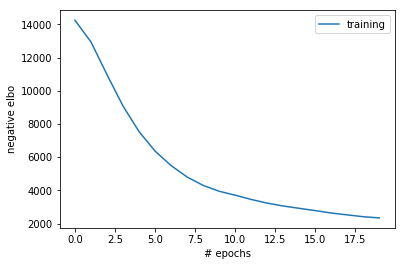

In [109]:
plt.plot(np.arange(NUM_EPOCHS) , - np.array(train_elbo) , label = 'training')
plt.xlabel('# epochs')
plt.ylabel('negative elbo')
plt.legend()
plt.show()

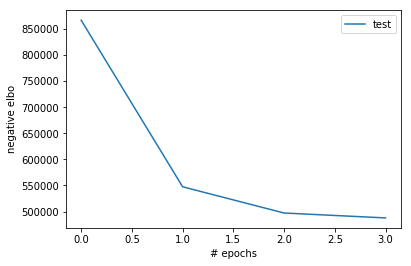

In [110]:
plt.plot(np.arange(NUM_EPOCHS/TEST_FREQUENCY) ,  - np.array(test_elbo) , label = 'test')
plt.xlabel('# epochs')
plt.ylabel('negative elbo')
plt.legend()
plt.show()

In [111]:
waveform = x_test[0]
decoded_waveform = VAE.reconstruct_img(vae, x=waveform)

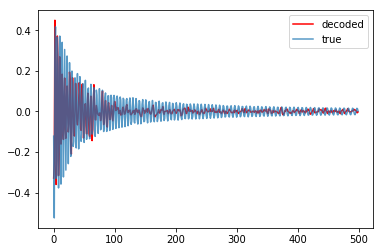

In [112]:
plt.plot(decoded_waveform[0].detach().numpy() , color = 'r' , label = 'decoded' , alpha = 1)
plt.plot( waveform.numpy() , label = 'true' , alpha = 0.75)
plt.legend()
plt.show()

In [113]:
residual = waveform - decoded_waveform[0] 
percentage_error = abs(residual)/waveform * 100

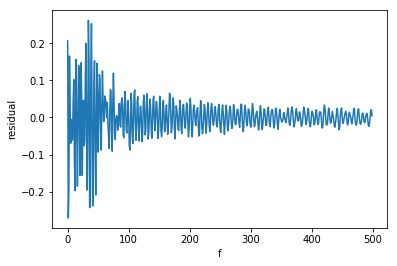

In [114]:
plt.plot(residual.detach().numpy())
plt.ylabel('residual')
plt.xlabel('f')
plt.show()

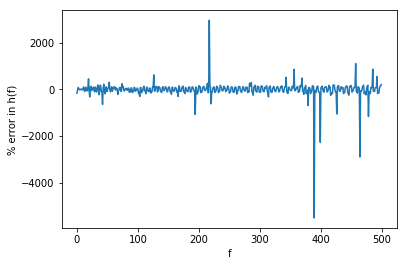

In [115]:
plt.plot(percentage_error.detach().numpy())
plt.ylabel('% error in h(f)')
plt.xlabel('f')
plt.show()

In [116]:
pyro.clear_param_store()